# DSCI100 Final Project Report: Predicting Subscription of Newsletter for a Video Game Research Server

Names: Christopher Lee, ...

## 1) Introduction

The research group led by UBC computer science professor Frank Wood set up a Minecraft server to collect data to learn more about people's video game behaviours. Demographics such as age, gender, and experience as well as the number of hours played on the server were tracked. A major challenge in running this project is ensuring how the team should target recruitment efforts. Therefore, this data analysis was done as an exploration in part with Dr. Wood's team. Our analysis will focus on one of the major issues related to targeting recruitment efforts, which is focusing on certain behaviours or characteristics in predicting subscription to a newsletter. 

In this project, we aimed to respond to this issue by exploring the question: 

**"Can age and ____ (played hours)?? predict whether or not a player will subscribe to the newsletter?"**

We attempted to answer this question by employing a predictive K-NN classfication model. Data from the "players.csv" dataset was used as it included the relevant predictor and response variables. This dataset includes 196 observations and 7 variables.

Variable information for the "players.csv" dataset:
1. `experience` (**character**):
    - player's experience playing Minecraft
2. `subscribe` (**logical**):
    - player's subscription status
3. `hashedEmail` (**character**):
    - player's hashed email
4. `played_hours` (**numeric (double)**):
    - player's total played hours on the server
5. `name` (**character**):
    - player's name
6. `gender` (**character**):
    - player's gender
7. `Age` (**numeric (double)**):
    - player's age

The dataset may include potential issues, such as NA values for some players' ages.

## 2) Methods & Results

To ensure reproducibility in our project, we will first set the seed since tools we will be using involve randomness.

In [2]:
set.seed(2025)
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

Next, we will load in the "players.csv" dataset. We will clean the data by selecting only the variables of interest: experience, played_hours, age, and subscribe.

Additionally, we will turn the predictor variable experience to a numeric, and response variable subscribe to a factor so it can be consistent with a typical KNN classification.

Based on level progression, we will assign:
- Beginner --> 1
- Amateur --> 2
- Regular --> 3
- Pro --> 4
- Veteran --> 5

Finally, we will remove any NA values to prevent issues later on.

In [18]:
# load data
player_data_url <- "https://raw.githubusercontent.com/chrislee330/dsci-100-project-indiv/refs/heads/main/data/players.csv"
players <- read_csv(player_data_url)
players <- players |> select(experience, Age, subscribe, played_hours) |>
                        mutate(subscribe = as.factor(subscribe)) |>
                        mutate(experience = recode(experience, "Beginner" = 1, "Amateur" = 2, "Regular" = 3, "Pro" = 4, "Veteran" = 5)) |>
                        filter(Age != "NA")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,Age,subscribe,played_hours
<dbl>,<dbl>,<fct>,<dbl>
4,9,TRUE,30.3
5,17,TRUE,3.8
5,17,FALSE,0.0
2,21,TRUE,0.7
3,21,TRUE,0.1
2,17,TRUE,0.0


We will first split the data into training and testing sets to prevent overfitting and ensuring that our model generalizes well on unseen data. We will only perform exploratory analysis and prediction only on the training set. We have decided to use 75% of the data in the training set and using the response varaible subscribe as the strata.

In [19]:
players_split = initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

Summary statistics of the training set:

In [20]:
summary(players_train)

   experience         Age        subscribe    played_hours    
 Min.   :1.000   Min.   :11.00   FALSE: 39   Min.   :  0.000  
 1st Qu.:2.000   1st Qu.:17.00   TRUE :106   1st Qu.:  0.000  
 Median :2.000   Median :20.00               Median :  0.100  
 Mean   :2.703   Mean   :21.45               Mean   :  5.792  
 3rd Qu.:4.000   3rd Qu.:23.00               3rd Qu.:  0.600  
 Max.   :5.000   Max.   :58.00               Max.   :218.100  

We will create exploratory scatterplot visualizations of the training set. These include the following:
- Relationship between Experience, Age, and Subscription Status of Players
- Relationship between Age, Played hours, and Subscription Status of Players
- Relationship between Played hours, Experience, and Subscription Status of Players

We will line up those variables on the axes, and use color to show subscription class. Because there are discrete values for experience, there will be five distinct layers.

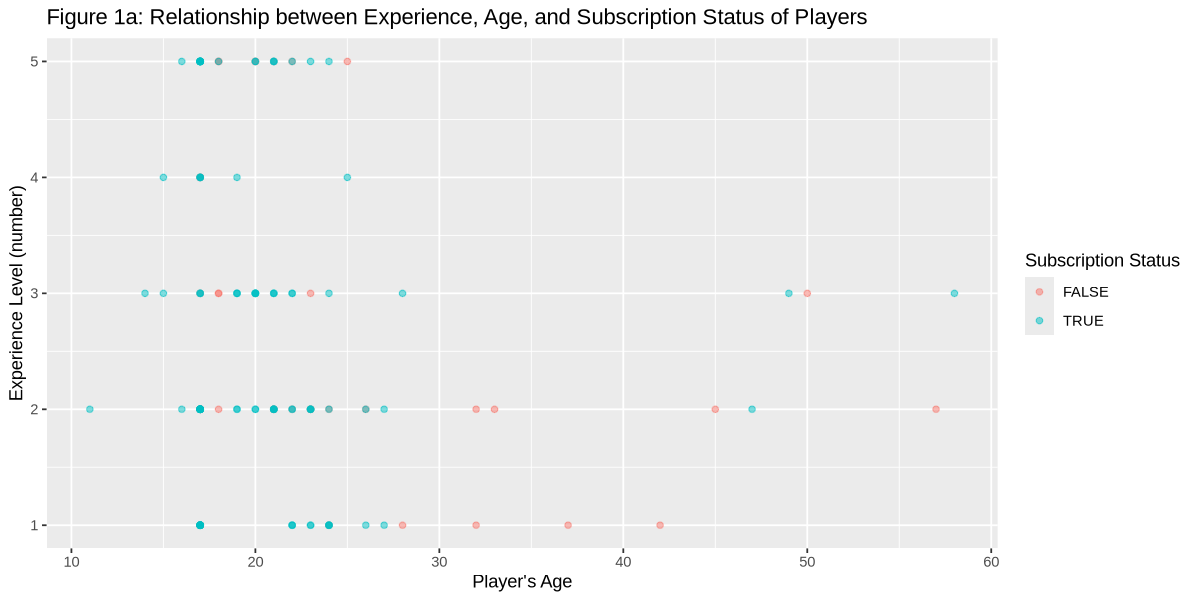

In [21]:
options(repr.plot.width = 10, repr.plot.height = 5)
training_plot_1 <- players_train |>
                    ggplot(aes(x = Age, y = experience, color = subscribe)) +
                        geom_point(alpha = 0.5) +
                        labs(x = "Player's Age", y = "Experience Level (number)", color = "Subscription Status") +
                        ggtitle("Figure 1a: Relationship between Experience, Age, and Subscription Status of Players")
training_plot_1

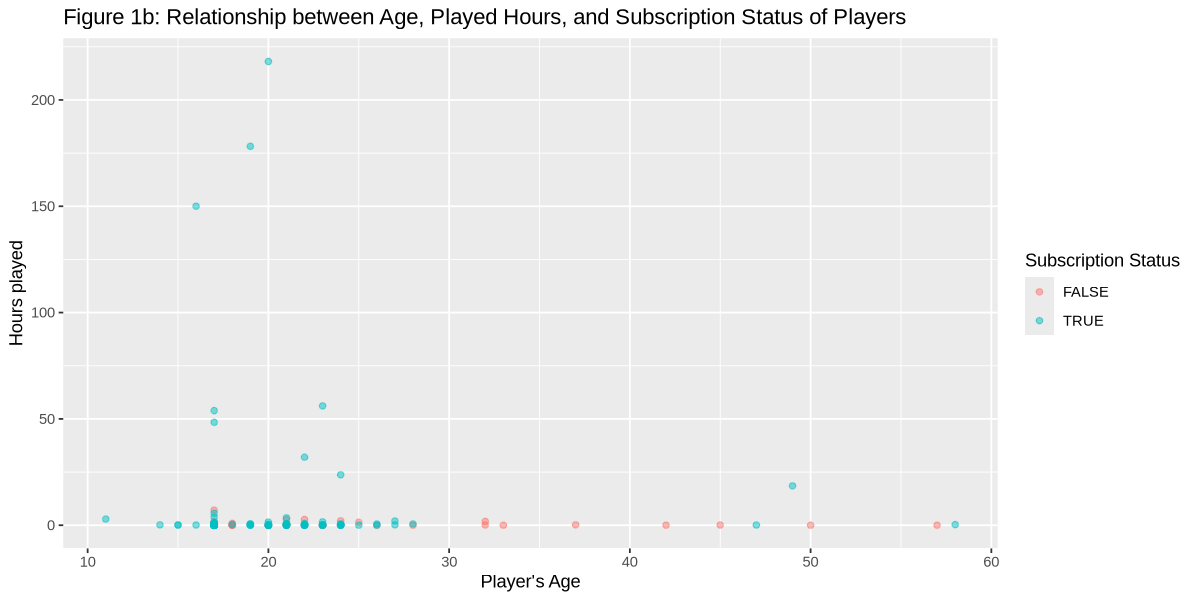

In [22]:
training_plot_2 <- players_train |>
                    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
                        geom_point(alpha = 0.5) +
                        labs(x = "Player's Age", y = "Hours played", color = "Subscription Status") +
                        ggtitle("Figure 1b: Relationship between Age, Played Hours, and Subscription Status of Players")
training_plot_2

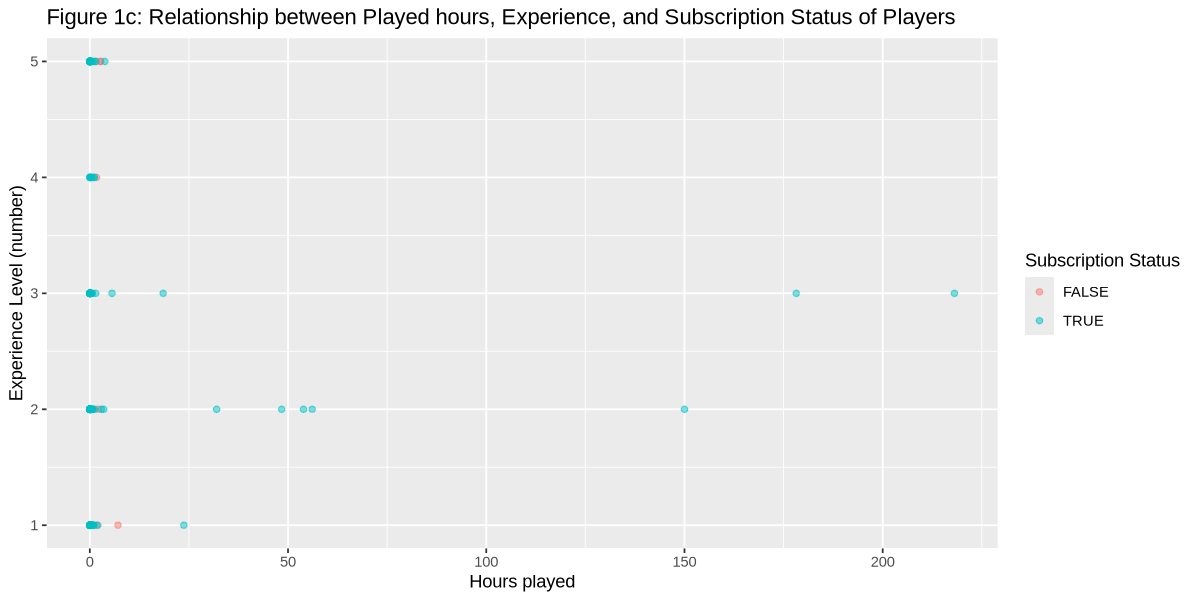

In [23]:
training_plot_3 <- players_train |>
                    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
                        geom_point(alpha = 0.5) +
                        labs(x = "Hours played", y = "Experience Level (number)", color = "Subscription Status") +
                        ggtitle("Figure 1c: Relationship between Played hours, Experience, and Subscription Status of Players")
training_plot_3

From the visualizations, there does not seem to be distinct relationships in the data. However, we can see that the demographic is mainly centered around people aged 20. Furthermore, there appears to be groups with clear class distinctions. Players with lower experience levels aged 30 to 40 seem to not subscribe, while players of higher experience levels around ages 15-25 seem to subscribe.

Although the experience is a bit distributed among players, there seems to be a disproportion of data centered around ages 16 to 25. Therefore, we will investigate by creating a histogram that compares age and subscription status.

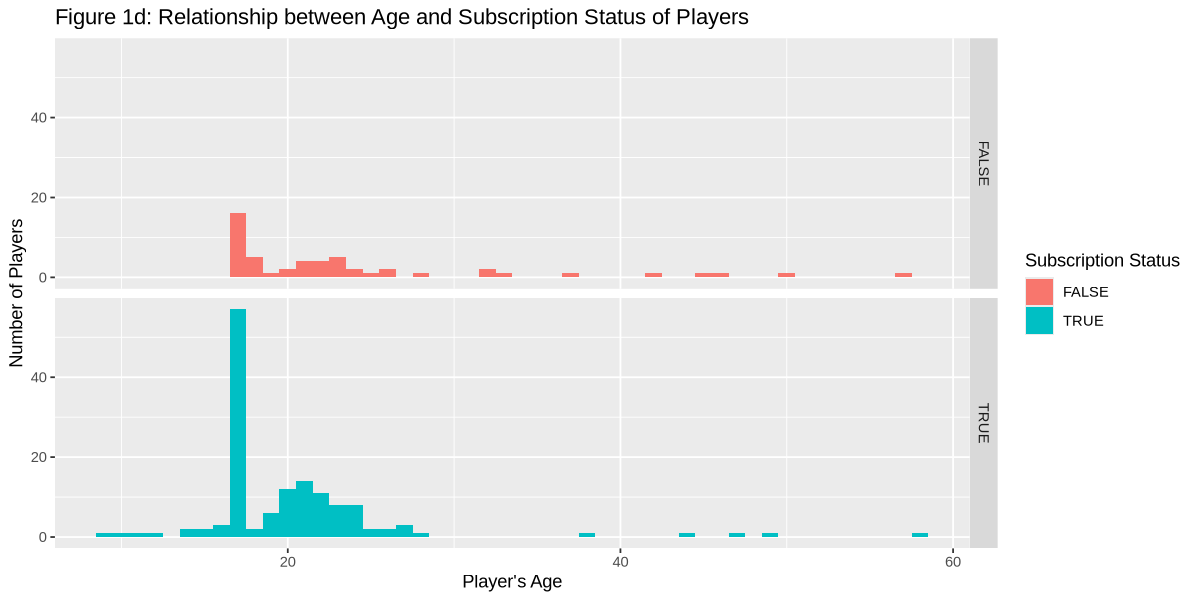

In [25]:
training_plot_4 <- players |>
                  ggplot(aes(x = Age, fill = subscribe)) +
                    geom_histogram(binwidth = 1) +
                    facet_grid(rows = vars(subscribe)) +
                    labs(x = "Player's Age", y = "Number of Players", fill = "Subscription Status") +
                    ggtitle("Figure 1d: Relationship between Age and Subscription Status of Players")
training_plot_4

From the visualization (Figure 1d), we see that there is indeed a lot of data around the ages of late teens to early 20s. 
We see that indeed, there is a lot of data centred around the ages of late teens to early 20s. Despite this being a possible concern for the quality of the predictive model, we will keep this in mind when evaluating its performance.

### Data Analysis

The data analysis will consist of setting up and evaluating a KNN classification model with three quantitative variables as predictors and a factor as a response variable. We will choose an optimal k-value by tuning the model. With this k-value, we will test the revised model against the testing data to evaluate its accuracy and metrics. Finally, we will feed the model new observations to predict and evaluate the model's performance on new unseen data.

Specifically:
1) create recipe and model specification for training data
    - tuning specification by setting neighbour = tune()
    - standardize data so all predictors have equal contributions
2) create a 5-fold cross validation to test values of k from 1 to 20 to choose the optimal value of k
3) create a workflow to combine the recipe, tuning specification, and information of cross-validation.
    - collect the accuracy of this workflow and show its results as a visualization and tibble